# `pygtfcode` `v1.0` (single fluid version) demo

## Import

In [1]:
import pygtfcode as gtf

## Instantiate config object

In [2]:
config = gtf.Config()

This holds all of the parameters that are used to instantiate a State object.  These can be modified before instantiating the State.  Once the State object exists, the config object becomes an attribute of the state.

In [3]:
config

Config(
  io=IOParams(model_no='<not evaluated>', model_dir='<not evaluated>', base_dir='/Users/yaronetokayer/YaleDrive/Research/SIDM/pygtfcode/examples', nlog=100000, drho_prof=0.1, drho_tevol=0.01, overwrite=True, chatter=True),
  grid=GridParams(rmin=0.01, rmax=200.0, ngrid=200),
  init=NFWParams(Mvir=3000000000.0, cvir=20.0, z=0.0),
  sim=SimParams(a=2.256758, b=1.38, c=0.75, rho_c_halt=1500.0, sigma_m=10.0, t_halt=1000.0),
  prec=PrecisionParams(eps_dr=1e-12, eps_dt=0.001, eps_du=0.0001, epsabs=1e-06, epsrel=1e-06, max_iter_cr=10, max_iter_dr=20000)
)

Change to a truncated NFW profile, optionally modify parameters.

In general, precision parameters are very finicky, and depending on the initial profile, the simulation may fail depending on what you choose.  For the trucated NFW, `eps_du = 1e-4` and `eps_du = 1e-3` generally work for certain choices of the cutoff energy.

In [7]:
config.init = "truncated_NFW"

config

Config(
  io=IOParams(model_no=1, model_dir='Model001', base_dir='/Users/yaronetokayer/YaleDrive/Research/SIDM/pygtfcode/examples', nlog=100000, drho_prof=0.1, drho_tevol=0.01, overwrite=True, chatter=True),
  grid=GridParams(rmin=0.01, rmax=200.0, ngrid=200),
  init=TruncatedNFWParams(Mvir=3000000000.0, cvir=20.0, z=0.0, Zt=0.05938, deltaP=1e-05),
  sim=SimParams(a=2.256758, b=1.38, c=0.75, rho_c_halt=1500.0, sigma_m=10.0, t_halt=1000.0),
  prec=PrecisionParams(eps_dr=1e-12, eps_dt=0.001, eps_du=0.0001, epsabs=1e-06, epsrel=1e-06, max_iter_cr=10, max_iter_dr=20000)
)

The model number is automatically set upon instatiating the state by inspecting the working directory and looking for the next available model number.  This can be overridden by specifying the model_no parameter.  If a simulation has already been run with that model number, files will be overwritten upon instantiation of the state.

In [ ]:
config.io.model_no = 0

# Instantiate the state

This can be constructed from the config object, or a previous experiment can be loaded with `State.from_dir()`

In [9]:
state = gtf.State.from_config(config)

Computing characteristic parameters for simulation...
Generating lookup for rho(phi)...
Computing potential profile for truncated NFW halo...
Integrating Poisson equation outward: r = 116.793421, phi = -0.000002
Setting up radial grid...
Initializing profiles...
Computing Menc: r = 115.625, m = 2.658
Generating lookup for v2 integrand...
Computing v2: r = 112.970, v2 = 0.000
State initialized.
Directory already exists: /Users/yaronetokayer/YaleDrive/Research/SIDM/pygtfcode/examples/Model001
Model information written to model_metadata.txt
Initial profiles written to disk.


At this point, a `model_metadata.txt` file has been written to the disk, as well as initial profiles.

Plot the current state (initial state):

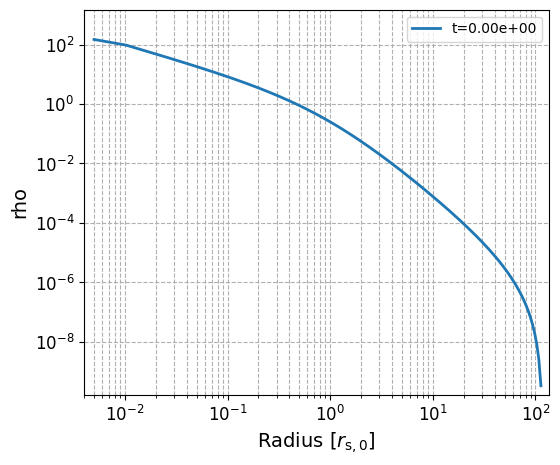

In [31]:
gtf.plot_snapshots(state, grid=True)

These, as well as all other plots, can be optionally saved to disk using the `filepath` keyword.

`show=True` prints the plot to stdout even when saving to a file.

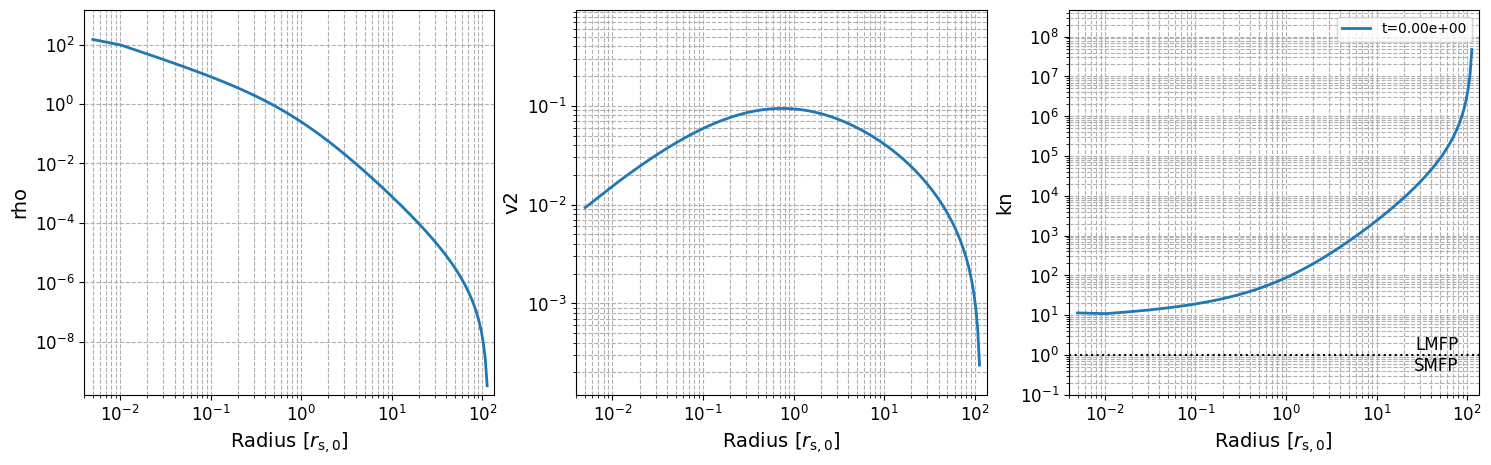

In [40]:
gtf.plot_snapshots(state, grid=True, profiles=['rho', 'v2', 'kn'], filepath='./Model000/initial.png', show=True)

# Run simulation

In each integration step:
- `dt` is determined based on the current state and tolerance parameters set in `config`.
- "Conduction step": the inernal energy is updated based on the luminosity at the bin edges.  This is done to linear order (heat is only conducted in adjascent bins).  This updates `u`, and in turn, `p` (asserting $p_i = (2/3) u_i * \rho_i$)
- "Revirialization step": Now that `p` has been updated with $\rho$ unchanged, hydrostatic equilibrium much be reestablished by adjusting the edges of the radial bin, keeping `M` invariant (Lagrangian framework), but updating `rho` and `p`.
- `v2`, `u` and other derived quantities are updated based on the results of the revirialization step.


By default, the system evolves until one of three stop conditions occur:
- central density exceeds 1500
- time exceeds 1000
- central density becomes a nan

Additional conditions can be added with keyword arguments into `run()`: `steps`, `stoptime`, `rho_c`


In [14]:
state.run()

Initial profiles written to disk.
Time evolution file initialized.
Log file initialized:
      step          time          <dt>         rho_c         v_max        Kn_min  <dt lim>  <dr lim>  <du lim>  <n_iter_cr>  <n_iter_dr>
         0  0.000000e+00           N/A  1.480969e+02  3.066874e-01  1.091955e+01       N/A       N/A       N/A          N/A          N/A
    100000  5.033403e+00  5.033403e-05  4.216706e+00  3.052256e-01  2.348740e+01  9.99e-02  2.82e-04  9.18e-01  0.00000e+00  2.00001e+00
    200000  1.287927e+01  7.845864e-05  3.094842e+00  3.021608e-01  2.625486e+01  7.81e-02  2.85e-04  7.74e-01  0.00000e+00  2.00000e+00
    300000  2.379780e+01  1.091853e-04  2.699657e+00  2.997891e-01  2.761491e+01  9.11e-02  2.85e-04  6.30e-01  0.00000e+00  2.00000e+00
    400000  3.947233e+01  1.567453e-04  2.536386e+00  2.985581e-01  2.818869e+01  1.20e-01  2.86e-04  5.66e-01  0.00000e+00  2.00000e+00
    500000  5.510663e+01  1.563431e-04  2.514355e+00  2.989083e-01  2.814724e+01  1.17e-0

If a simulation has already been fully or partially completed, we can also load it from the directory of output files:

Here you can use the optional `snapshot` keyword to load the simulation from a state other than the latest one.

In [32]:
state = gtf.State.from_dir('/Users/yaronetokayer/YaleDrive/Research/SIDM/pygtfcode/examples/Model000')

Set config from metadata.
Computing characteristic parameters for simulation...
Generating lookup for rho(phi)...
Computing potential profile for truncated NFW halo...
Integrating Poisson equation outward: r = 116.793421, phi = -0.000002
Setting state variables from snapshot...
State loaded.


# Inspect/present results

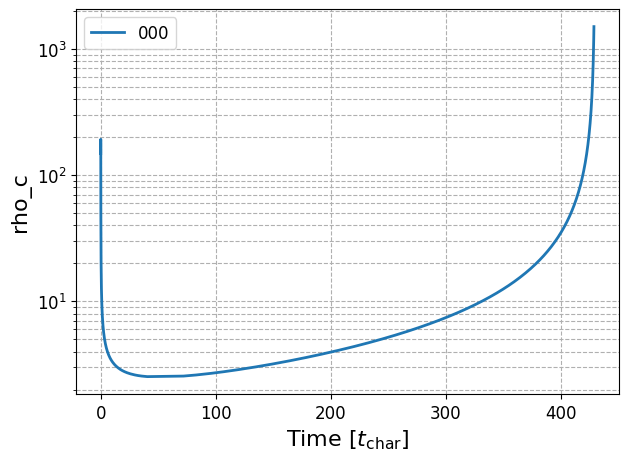

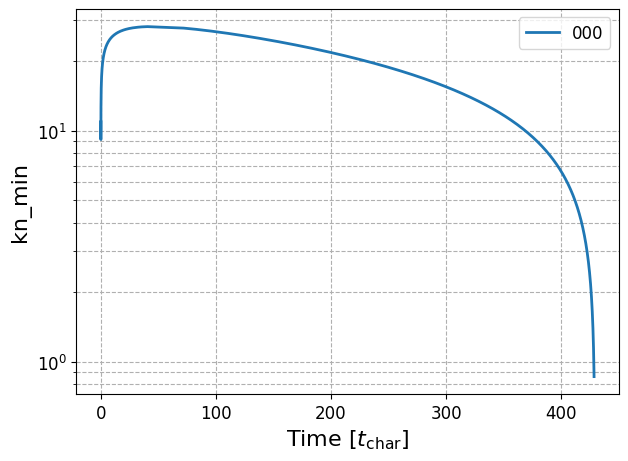

In [33]:
state.plot_time_evolution(grid=True)
state.plot_time_evolution(grid=True, quantity='kn_min')

`plot_time_evolution` also exists as a standalone function and can be used to compare multiple simulations in the same directory:

Here, Model000 is the truncated NFW profile evolved in this notebook, Model001 is an alpha-beta-gamma profile, and Model002 is an NFW profile.

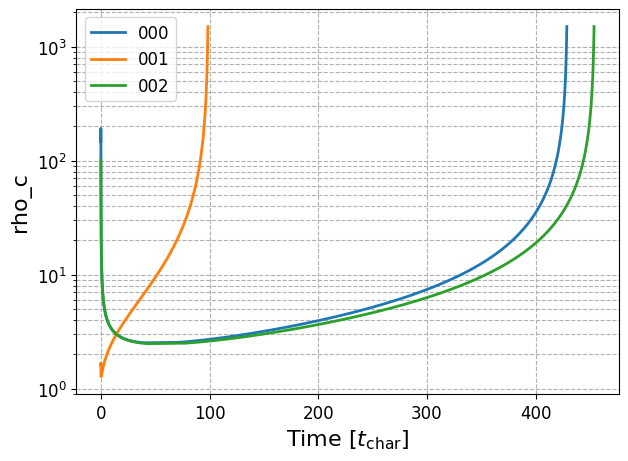

In [39]:
gtf.plot_time_evolution(
    models=[0,1,2], 
    quantity='rho_c', 
    grid=True, 
    base_dir='/Users/yaronetokayer/YaleDrive/Research/SIDM/pygtfcode/examples',
    filepath='./compare.png',
    show=True
    )

When plotting snapshots, the index `-1` corresponds to the last snapshot.

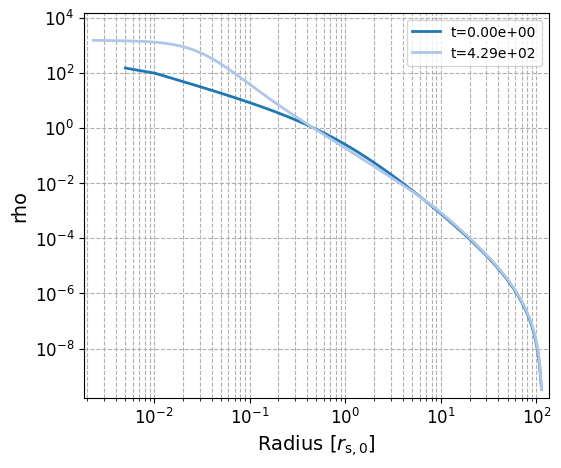

In [35]:
state.plot_snapshots(grid=True, snapshots=[0,-1])

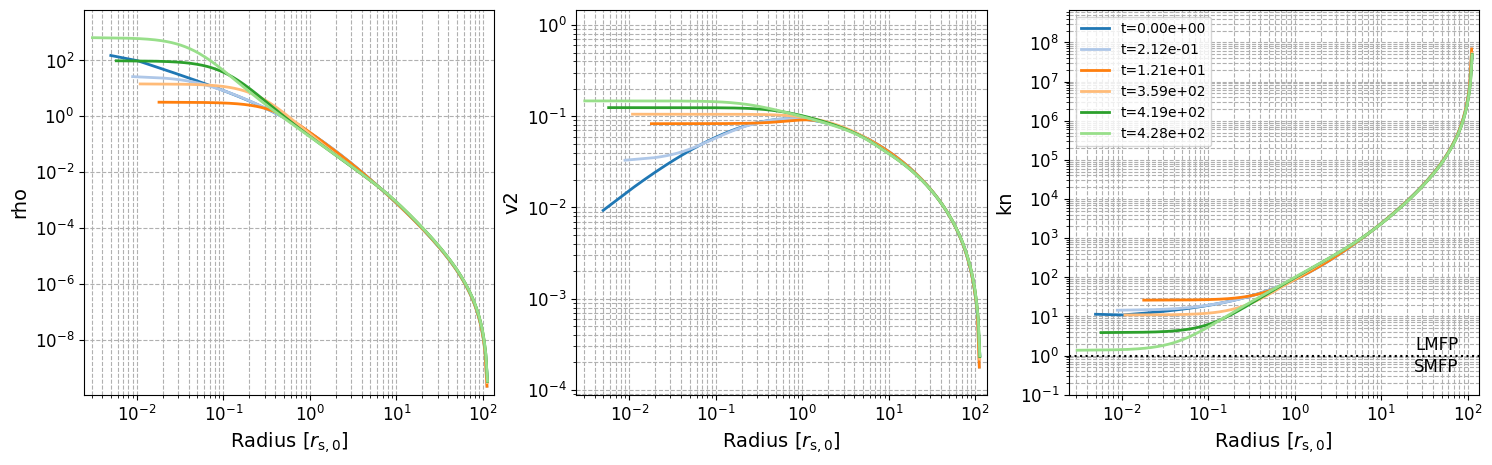

In [36]:
snapshots = list(range(0, 101, 20))

state.plot_snapshots(grid=True, snapshots=snapshots, profiles=['rho', 'v2', 'kn'])

# Animate the evolution

In [19]:
state.make_movie(grid=True, profiles=['rho', 'v2', 'kn'])

Generating 110 frames...


Frames: 100%|██████████| 110/110 [01:02<00:00,  1.77frame/s]


Compiling into a movie using ffmpeg...
Deleting frames...
Movie saved to /Users/yaronetokayer/YaleDrive/Research/SIDM/pygtfcode/examples/Model001/movie_rho_v2_kn.mp4


`make_movie()` and `plot_snapshots()` also exist as standalone functions and noy only as State methods.  See, e.g., `help(gtf.make_movie)` for usage.

In [27]:
help(gtf.make_movie), help(gtf.plot_snapshots)

Help on function make_movie in module pygtfcode.plot.snapshot:

make_movie(model, filepath=None, base_dir=None, profiles='rho', grid=False, fps=20)
    Animate up to three profiles for one simulation

    Arguments
    ---------
    model : State object, Config object, or model_no
        Each model can be a State, Config, or integer model number.
    filepath : str, optional
        Save the plot to this file.  Defaults to '/base_dir/ModelXXX/movie_{profiles}.mp4'
    base_dir : str, optional
        Required if any model is passed as an integer.  The directory in which all ModelXXX subdirectories reside.
    profiles : str or list of str, optional
        Profiles to plot.  Options are 'rho', 'm', 'v2', 'p', 'trelax', 'kn'
    grid : bool, optional
        If True, shows grid on axes
    fps : int, optional
        Frames per second for the output movie. Default is 20

    Returns
    -------
    None
        Saves the movie as an MP4 file in the model directory.

Help on function pl

(None, None)